# Image-to-Speech


## Business Purpose

### This features can be integrated into an application which can be used by people while fishing. As for beginners if they want to identify to what specie a particular fish belongs to then they can use this app to find it out. All they would need to do is click a picture when they fish and the app will convert the image into speech for them. 


### For this project I am using Azure Custom Vision to train different spieces of fishes and then using custom vision APIs to test the model.

### Using these API keys these images are converted into text and then GTTS(Google Text To Speech) is used to converted the text into speech. 



In [ ]:
#copy and paste your Custom Vision API key, project_id,iteration_id and endpoint URL from Azure into the variables below:
prediction_key = '03c089e864b84e8f9e5b852e04f2f338'
cv_endpoint = 'https://fooddemo.cognitiveservices.azure.com/'
project_id = 'ae8386f7-b8b8-4502-a501-e5a028921295'
iteration_id = '78073cb1-53a2-4e56-8b1c-1277a4d8b70e'

In [2]:
! pip install azure-cli
!pip install azure-cognitiveservices-vision-customvision
!pip install gTTS
!pip install scikit-plot

#import libraries
import matplotlib.pyplot as plt
import seaborn as sn
import IPython
import sklearn 
from IPython.display import Image as ipImage, display
from IPython.display import clear_output
import io
import numpy as np
import pandas as pd
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateEntry
from msrest.authentication import ApiKeyCredentials
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import scikitplot as skplt
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics

  Created wheel for vsts-cd-manager: filename=vsts_cd_manager-1.0.2-cp37-none-any.whl size=26733 sha256=d64b73cdb4318f6abec3d9926f07226bcbc84b6c590cbb2bb109acf40e5c9a9c
  Stored in directory: C:\Users\Archana\AppData\Local\pip\Cache\wheels\11\cc\8b\16184f7bc7564f91951b5d46d6e32fa58c9587e2ce90861892
  Created wheel for jsondiff: filename=jsondiff-1.2.0-cp37-none-any.whl size=6547 sha256=a8720462b9a1370b6e742733a3bd066b5110f17d76b388d5bec1094ebc19c4ad
  Stored in directory: C:\Users\Archana\AppData\Local\pip\Cache\wheels\08\ad\e9\7815207aa5206fdead5c7b565c57dd8fd56ab559c847a7be3d
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.7.2-cp37-none-any.whl size=140956 sha256=0e46cc6b80a85ee90f2368b721d77d4fa40d484fb2ef20773b66b0d4f576d458
  Stored in directory: C:\Users\Archana\AppData\Local\pip\Cache\wheels\03\65\47\b6700d23b7529a49513f7601b4f96174a4fa9efdbec03e7ea3
  Created wheel for jsmin: filename=jsmin-2.2.2-cp37-none-any.whl size=13925 sha256=e7c181b7f076e6b8

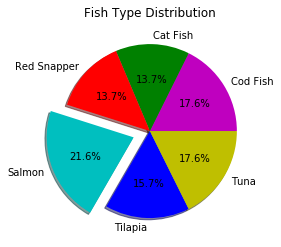

In [5]:

# No.of Training Images per Fish
number = [9,7,7,11,8,9]
# Colors to be used in the pie chart
colors = ['m', 'g', 'r', 'c','b','y']
# Labels of the fish type
labels = 'Cod Fish', 'Cat Fish', 'Red Snapper', 'Salmon','Tilapia','Tuna'
# To separate out Salmon as it has the max distribution
explode = (0, 0, 0, 0.2,0,0)
# Plot the Pie Chart
plt.pie(number, colors=colors, labels= labels,explode=explode, shadow=True,autopct='%1.1f%%')
# Title of the PIe Chart
plt.title('Fish Type Distribution')
# Display Pie Chart
plt.show()

In [6]:
## Test image url - Cod fish

img_url1 = "https://media.npr.org/assets/img/2015/06/15/gettyimages-458906766_custom-233357e7fe6566c5ee08e1eed7c5ecf714b7d7e3-s800-c85.jpg"

##Test image url - Red Snapper

img_url2 = "https://www.harteresearchinstitute.org/sites/default/files/styles/node_hero/public/news/IMG_4997.JPG?itok=Nh67etFc"

##Test image url - Tuna

img_url3 = "https://swfsc.noaa.gov/uploadedImages/Divisions/FRD/Large_Pelagics/Tuna/MG_iPics_%202403.2.JPG"

##Test image url - Cat Fish

img_url4 = "https://assets.caboosecms.com/posts/3853_huge.jpg?1534868218"

##Test image url - Salmon

img_url5 = "https://static.seattletimes.com/wp-content/uploads/2018/07/salmon-tzr-780x501.jpg"


In [8]:
# Store image urls in a list
test_images = (img_url1,img_url2,img_url3,img_url4,img_url5)
count = 0
# For loop to print all the test images 
for test_image in test_images:
  img = ipImage(url=test_image, width=400)
  display(img)
  count +=1

In [13]:
# Creating an empty Dataframe with column names only
df = pd.DataFrame(columns=['index','Image_URL', 'Actual_TAG', 'APIPredicted_TAG','Output','TTS'])

# Feeding data to the dataframe
df = df.append({'index': 0, 'Image_URL': 'https://media.npr.org/assets/img/2015/06/15/gettyimages-458906766_custom-233357e7fe6566c5ee08e1eed7c5ecf714b7d7e3-s800-c85.jpg', 'Actual_TAG': '1','APIPredicted_TAG': ''}, ignore_index=True)
df = df.append({'index': 1, 'Image_URL': 'https://www.harteresearchinstitute.org/sites/default/files/styles/node_hero/public/news/IMG_4997.JPG?itok=Nh67etFc', 'Actual_TAG': '1','APIPredicted_TAG': ''}, ignore_index=True)
df = df.append({'index': 2, 'Image_URL': 'https://swfsc.noaa.gov/uploadedImages/Divisions/FRD/Large_Pelagics/Tuna/MG_iPics_%202403.2.JPG', 'Actual_TAG': '1','APIPredicted_TAG': ''}, ignore_index=True)
df = df.append({'index': 3, 'Image_URL': 'https://assets.caboosecms.com/posts/3853_huge.jpg?1534868218', 'Actual_TAG': '1','APIPredicted_TAG': ''}, ignore_index=True)
df = df.append({'index': 4, 'Image_URL': 'https://static.seattletimes.com/wp-content/uploads/2018/07/salmon-tzr-780x501.jpg', 'Actual_TAG': '1','APIPredicted_TAG': ''}, ignore_index=True)
df = df.append({'index': 5, 'Image_URL': 'https://content.osgnetworks.tv/gameandfishing/content/photos/gaf-GACatfish.jpg', 'Actual_TAG': '0','APIPredicted_TAG': ''}, ignore_index=True)
df = df.append({'index': 6, 'Image_URL': 'https://www.pacb.com/wp-content/uploads/Portrait_of_Cod-300x219.jpg', 'Actual_TAG': '1','APIPredicted_TAG': ''}, ignore_index=True)
df = df.append({'index': 7, 'Image_URL': 'https://www.sportfishingmag.com/resizer/OnH72YpeaSHNv0fjga2kbrIqeTE=/760x506/arc-anglerfish-arc2-prod-bonnier.s3.amazonaws.com/public/6UH2C26VQ3NV7DG6NVMKXN4FWI.jpg', 'Actual_TAG': '1','APIPredicted_TAG': ''}, ignore_index=True)
df = df.append({'index': 8, 'Image_URL': 'https://www.citarella.com/media/catalog/product/cache/1/mobile_image/9df78eab33525d08d6e5fb8d27136e95/0/2/024028700000_02_1_1400x950_.jpg', 'Actual_TAG': '1','APIPredicted_TAG': ''}, ignore_index=True)
df = df.append({'index': 9, 'Image_URL': 'https://d178ivhysawugh.cloudfront.net/media/l/2400x1260/1588167478/tilapia-brood-fish.JPG', 'Actual_TAG': '1','APIPredicted_TAG': ''}, ignore_index=True)

# Glimpse of the data
df.head(6)

,index,Image_URL,Actual_TAG,APIPredicted_TAG,Output,TTS
0,0,https://media.npr.org/assets/img/2015/06/15/ge...,1,,NaN,NaN
1,1,https://www.harteresearchinstitute.org/sites/d...,1,,NaN,NaN
2,2,https://swfsc.noaa.gov/uploadedImages/Division...,1,,NaN,NaN
3,3,https://assets.caboosecms.com/posts/3853_huge....,1,,NaN,NaN
4,4,https://static.seattletimes.com/wp-content/upl...,1,,NaN,NaN
5,5,https://content.osgnetworks.tv/gameandfishing/...,0,,NaN,NaN


In [76]:
import requests

count = 0
tempstore = ''
# Fill in your own values HERE
prediction_key = '03c089e864b84e8f9e5b852e04f2f338'
cv_endpoint = 'https://fooddemo.cognitiveservices.azure.com/'
project_id = 'ae8386f7-b8b8-4502-a501-e5a028921295'
iteration_id = '78073cb1-53a2-4e56-8b1c-1277a4d8b70e'
# Build the header json for the request
headers = {
    "Prediction-key": prediction_key
}

# Define the endpoint
url = "https://fooddemo.cognitiveservices.azure.com/customvision/v3.0/Prediction/ae8386f7-b8b8-4502-a501-e5a028921295/classify/iterations/Iteration7/url"

    
# Build and send a POST request
for image_url in df.Image_URL:
  # Build the data json for the request
  data = {"Url": image_url }
  response = requests.post(url, headers=headers, data=data)
  response = response.json()
 
    
  # The key Project will be in a valid 200 response
  if ('project' in response or 'Project' in response):
    # for loop to get the results
      for pred in response['predictions']:
        # nested if statement to capture the output for probablities greater than 60%
        probability = pred['probability'] if 'probability' in pred else pred['Probability'] 
        if probability > 0.70:
          tagName = pred['tagName'] if 'tagName' in pred else pred['TagName']
          # nested if statement to check each of the output with tags that are fed to the Custom Vision    
          if tagName == 'Cat Fish':
            
            tempstore = 'This is a Cat Fish'
            print(tempstore)
            #append the dataframe accordingly
            df.loc[count, 'APIPredicted_TAG'] = 1
            df.loc[count,'Output'] = tempstore
            break
          # nested if statement to check each of the output with tags that are fed to the Custom Vision  
          elif tagName == 'Cod Fish':
            clear_output 
            
            tempstore = 'This is a Cod Fish'
            print(tempstore)
            #append the dataframe accordingly
            df.loc[count, 'APIPredicted_TAG'] = 1
            df.loc[count,'Output'] = tempstore
            break 
          # nested if statement to check each of the output with tags that are fed to the Custom Vision  
          elif tagName == 'Salmon':
            clear_output
            # store 'The fish is Salmon'
            tempstore = 'This is a Salmon'
            print(tempstore)
            #append the dataframe accordingly
            df.loc[count, 'APIPredicted_TAG'] = 1
            df.loc[count,'Output'] = tempstore
            break
          # nested if statement to check each of the output with tags that are fed to the Custom Vision  
          elif tagName == 'Tuna':
            clear_output
            # store 'The fish is Tuna'
            tempstore = 'This is a Tuna'
            print(tempstore)
            #append the dataframe accordingly
            df.loc[count, 'APIPredicted_TAG'] = 1
            df.loc[count,'Output'] = tempstore
            break
          # nested if statement to check each of the output with tags that are fed to the Custom Vision   
          elif tagName == 'Red Snapper':
            clear_output
            # store 'Theh fish is Red Snapper'
            tempstore = 'This is a Red Snapper'
            print(tempstore)
            #append the dataframe accordingly
            df.loc[count, 'APIPredicted_TAG'] = 1
            df.loc[count,'Output'] = tempstore
            break
        elif tagName == 'Tilapia':
            clear_output 
            
            tempstore = 'This is a Tilapia'
            print(tempstore)
            #append the dataframe accordingly
            df.loc[count, 'APIPredicted_TAG'] = 1
            df.loc[count,'Output'] = tempstore
            break 
        # If Custom Vision is not able to Tag the fish or if their probability is less than 60%
        else:
          clear_output
          #store Notag returned as output
          tempstore_notag = 'No tag returned'
          print(tempstore_notag)
          # append the dataframe accordingly
          df.loc[count, 'APIPredicted_TAG'] = 0
          df.loc[count,'Output'] = tempstore_notag
          break
       
# To catch system error 
  else:
      print(response)
  count +=1

This is a Cod Fish
This is a Red Snapper
This is a Tuna
This is a Cat Fish
No tag returned
This is a Cat Fish
This is a Cod Fish
No tag returned
This is a Salmon
No tag returned


In [77]:
df.head(9)

,index,Image_URL,Actual_TAG,APIPredicted_TAG,Output,TTS
0,0,https://media.npr.org/assets/img/2015/06/15/ge...,1,1,This is a Cod Fish,1
1,1,https://www.harteresearchinstitute.org/sites/d...,1,1,This is a Red Snapper,1
2,2,https://swfsc.noaa.gov/uploadedImages/Division...,1,1,This is a Tuna,1
3,3,https://assets.caboosecms.com/posts/3853_huge....,1,1,This is a Cat Fish,1
4,4,https://static.seattletimes.com/wp-content/upl...,1,0,No tag returned,1
5,5,https://content.osgnetworks.tv/gameandfishing/...,0,1,This is a Cat Fish,1
6,6,https://www.pacb.com/wp-content/uploads/Portra...,1,1,This is a Cod Fish,1
7,7,https://www.sportfishingmag.com/resizer/OnH72Y...,1,0,No tag returned,1
8,8,https://www.citarella.com/media/catalog/produc...,1,1,This is a Salmon,1


In [60]:
from gtts import gTTS
# This module is imported so that we can  
# play the converted audio 
import os 
# Language in which you want to convert 
language = 'en'
count = 0
# Passing the text and language to the engine,  
# here we have marked slow=False. Which tells  
# the module that the converted audio should  
# have a high speed 
# Saving the converted audio in a mp3 file named Tempstore{count}
for tempstore in df.Output:
  myobj = gTTS(text=tempstore, lang=language, slow=False)
  myobj.save("tempstore.mp3".format(count))
  # append the dataframe with 1 if the text is recognized
  df.loc[count, 'TTS'] = 1
  count +=1

In [64]:
import IPython 
from IPython.display import clear_output
IPython.display.Audio('tempstore1.mp3', autoplay=True)

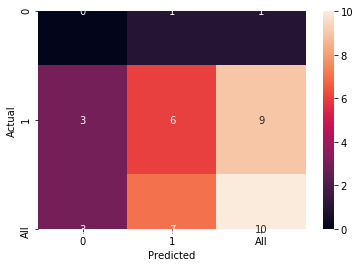

In [65]:
# Confusion Matrix

df_confusion = pd.crosstab(df.Actual_TAG, df.APIPredicted_TAG, rownames=['Actual'], colnames=['Predicted'], margins=True)
sn.heatmap(df_confusion, annot=True)

In [139]:
import time
# To delay running this code by 5 mins so that the audio doesnot overlap
time.sleep(5)
image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSCZXNjXszThwPcUA4djEYjd2w6YjWzLHggYhYwcy_yfk7HipnY&usqp=CAU'
# Url to be sent to Custom Vision
data = {"Url": image_url}
# Build and send a POST request
# Build the data json for the request
response = requests.post(url, headers=headers, data=data)
response = response.json()
  # The key Project will be in a valid 200 response
if 'project' in response:
    for pred in response['predictions']:
        probability = pred['probability'] if 'probability' in pred else pred['Probability']
        #if statement to capture the output for probablities greater than 70%
        if probability > 0.50:
            tagName = pred['tagName'] if 'tagName' in pred else pred['TagName']
            # nested if statement to check each of the output with tags that are fed to the Custom Vision 
            if tagName == 'Salmon':
                # Store the result
                tempstore = ('I am {0}% sure that this is Salmon'.format(int(probability*100)))
                print(tempstore)
                break
            # nested if statement to check each of the output with tags that are fed to the Custom Vision 
            elif tagName =='Tuna':
                clear_output 
                # Store the result
                tempstore = ('I am {0}% sure that this is Tuna'.format(int(probability*100)))
                print(tempstore)
                break 

            # nested if statement to check each of the output with tags that are fed to the Custom Vision 
            elif tagName == 'Tulapia':
                clear_output
                # Store the result
                tempstore = ('I am {0}% sure that this is Tulapia'.format(int(probability*100)))
                print(tempstore)
                break
            # nested if statement to check each of the output with tags that are fed to the Custom Vision 
            elif tagName == 'Cat Fish':
                clear_output
                # Store the result
                tempstore = ('I am {0}% sure that this is a Cat Fish'.format(int(probability*100)))
                print(tempstore)
                break 
            # nested if statement to check each of the output with tags that are fed to the Custom Vision 
            elif tagName == 'Cod Fish':
                clear_output
                # Store the result
                tempstore = ('I am {0}% sure that this is Cod Fish'.format(int(probability*100)))
                print(tempstore)
                break
            elif tagName == 'Red Snapper':
                clear_output
                # Store the result
                tempstore = ('I am {0}% sure that this is Red Snapper'.format(int(probability*100)))
                print(tempstore)
                break
        # If Custom Vision is not able to Tag the food item or their probability is less than 70%
        else:
          clear_output
          #store the result
          tempstore = ('No tag returned')
          print(tempstore)
          break
# To catch system error       
else:
    print(response)
# Display the Image sent in to Custom Vision
img = ipImage(url=image_url, width=400)
display(img)
# Call google text to speech library
language = 'en'
myobj = gTTS(text=tempstore, lang=language, slow=False)
# save the output
myobj.save("tempstore.mp3") 
#Play the output
IPython.display.Audio('tempstore.mp3', autoplay=True)

I am 99% sure that this is Tulapia


## I have trained this model with 82% accuracy. More images can be trained to get better results.

## 